---
### Advanced voorbeeld: niet-lineare SVR

Voor de liefhebbers een voorbeeld van SVR waarbij er een niet-lineair verband is tussen de variabelen. Je kan als extra oefening polynomial regression ook op deze dataset toepassen en de resultaten vergelijken met de SVR-model resultaten.

dataset: `position_salaries.csv`

We willen weten of er, in eerste instantie, een linear verband is tussen functie-niveau en salaris, en of we dan kunnen voorspellen het salaris aan de hand van een functie-niveau.

Bron:
- Naibei, Bejamin (2022) [Getting Started with Support Vector Regression in Python](https://www.section.io/engineering-education/support-vector-regression-in-python/).

In [1]:
# helper functions

%matplotlib inline

import sys
import os
from pathlib import Path
from packaging import version
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Excel CSV-file
def load_csv_pd_data(path, filename, 
                     names=None, 
                     delim_whitespace=False
                    ):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel CSV file `filename`,
           stored in a folder `path`.
           @names: header-names of columns
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    # DEBUG: print(csv_path)
    return pd.read_csv(csv_path,
                       delim_whitespace=delim_whitespace,
                       names=names
                      )

# Excel XLS-file
def load_xls_pd_data(path, filename, 
                     names=None
                    ):
    '''
    load_xls_pd_data() - construct a pandas DataFrame object 
           from data in a Excel xls-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    xls_path = os.path.join(path, filename)
    # DEBUG: print(xls_path)
    return pd.read_excel(xls_path,
                         names=names
                        )

# Create the `images/training_linear_models` folder
IMAGES_PATH = Path() / "images" / "training_svm_regression_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, 
                format=fig_extension, 
                dpi=resolution
    )


In [2]:
# get the dataset
filename = "position_salaries.csv"
path = "./data/"
dataset = load_csv_pd_data(path, filename)

# our dataset in this implementation is small...
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Position  10 non-null     object
 1   Level     10 non-null     int64 
 2   Salary    10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 372.0+ bytes


C:\Users\hq0132410\AppData\Local\Temp\ipykernel_35064\3195170361.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(csv_path,


In [3]:
# ... thus we can print it.
print(dataset)

            Position  Level   Salary
0   Business Analyst      1    45000
1  Junior Consultant      2    50000
2  Senior Consultant      3    60000
3            Manager      4    80000
4    Country Manager      5   110000
5     Region Manager      6   150000
6            Partner      7   200000
7     Senior Partner      8   300000
8            C-level      9   500000
9                CEO     10  1000000


De bovenstaande dataset bevat 10 instanties. Het belangrijkste kenmerk in deze dataset is de kolom *Level*. De kolom *Position* is slechts een beschrijving van de kolom *Level* en voegt daarom geen waarde toe aan onze analyse.

Daarom zullen we de dataset opsplitsen in een set independend (kenmerken / *features*) en dependend variabelen (studie / *target*).

Zoals hierboven besproken, hebben we slechts één kenmerk in deze dataset. Daarom splitsen we de dataset in onze studievariabele (`y`) en de kenmerk (`X`), zoals weergegeven in de volgende code:

In [4]:
# split the data into features and target variable seperately
X = dataset.iloc[:, 1:-1].values # set of features
y = dataset.iloc[:, -1].values # set of study variable

In [5]:
# look at the features set
print(X)

[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]


Uit deze uitvoer is het duidelijk dat de variabele `X` een 2D-array is. Op dezelfde manier kunnen we de variabele `y` bekijken:

In [6]:
print(y)

[  45000   50000   60000   80000  110000  150000  200000  300000  500000
 1000000]


Uit de bovenstaande uitvoer blijkt dat de variabele `y` een vector is, d.w.z. een 1D-array.

We moeten opmerken dat de waarden van `y` enorm zijn in vergelijking met `X`.

Als we daarom een model op deze gegevens implementeren, zal de studievariabele de kenmerkvariabele domineren, zodat zijn bijdrage aan het model wordt verwaarloosd.

Hierdoor zullen we deze studievariabelen moeten schalen naar hetzelfde bereik als de geschaalde kenmerkvariabelen.

De uitdaging hier is dat de `StandardScaler`, de klasse, uit scikit-learn, die we gebruiken om de gegevens te schalen, een 2D-array opneemt, anders retourneert het een fout.

Hierdoor moeten we onze variabele `y` hervormen van 1D naar 2D. Onderstaande code doet dit voor ons:

In [7]:
y_p = y.reshape(-1,1)

In [8]:
print(y_p)

[[  45000]
 [  50000]
 [  60000]
 [  80000]
 [ 110000]
 [ 150000]
 [ 200000]
 [ 300000]
 [ 500000]
 [1000000]]


Nu importeren  we de `StandardScalar` klasse en schalen de `X` en `y_p`variabelen afzonderlijk:

In [9]:
from sklearn.preprocessing import StandardScaler

StdS_X = StandardScaler()
StdS_y = StandardScaler()
X = StdS_X.fit_transform(X)
y_p = StdS_y.fit_transform(y_p)

In [10]:
print(f"Scaled X:\n{X}")
print(f"Scaled y_p:\n{y_p}")

Scaled X:
[[-1.5666989 ]
 [-1.21854359]
 [-0.87038828]
 [-0.52223297]
 [-0.17407766]
 [ 0.17407766]
 [ 0.52223297]
 [ 0.87038828]
 [ 1.21854359]
 [ 1.5666989 ]]
Scaled y_p:
[[-0.72004253]
 [-0.70243757]
 [-0.66722767]
 [-0.59680786]
 [-0.49117815]
 [-0.35033854]
 [-0.17428902]
 [ 0.17781001]
 [ 0.88200808]
 [ 2.64250325]]


Zoals we kunnen zien aan de hand van de verkregen uitvoer, zijn beide variabelen geschaald binnen het bereik -3 en +3. Netjes!

Onze gegevens zijn nu klaar om met **SVR**-model te implementeren.

Maar voordat we dit kunnen doen, willen we eerst de gegevens visualiseren om te leren wat er het beste bij het SVR-model past.

We maken een *scatterplot* van onze twee variabelen.

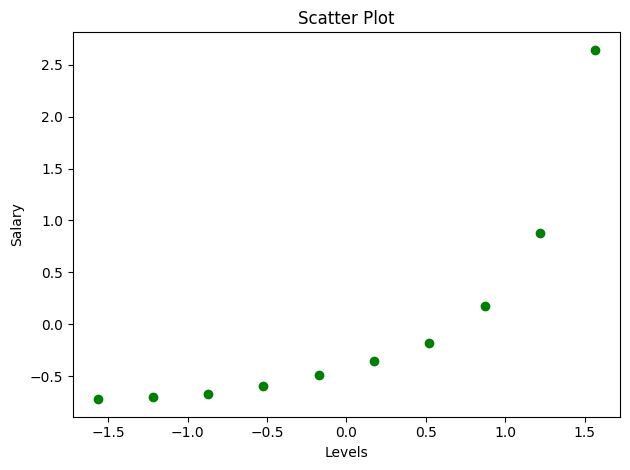

In [11]:
# plotting the training set
plt.scatter(X, y_p, color = 'green') 

plt.title('Scatter Plot') # adding a tittle to our plot
plt.xlabel('Levels') # adds a label to the x-axis
plt.ylabel('Salary') # adds a label to the y-axis

save_fig("SVR_advanced-training_data")
plt.show()

De grafiek toont een **niet-lineair verband** tussen de functie-niveaus (*Levels*) en het salaris (*Salary*).

Hierdoor kunnen we de lineaire SVR niet gebruiken om deze gegevens te modelleren. Om deze relatie beter vast te leggen, zullen we daarom de SVR gebruiken met een kernelfunctie, net zoals dat ook gedaan is bij SVM voor (niet-lineaire) classificatie.

Omdat we hebben verklaard dat onze gegevens niet-lineair zijn, zullen we deze doorgeven aan een kernel die **Radial Basis Function** (RBF) wordt genoemd. Zie help-informatie over `SVR`

NB. De variabele `y_p` is een 2D-array. Als je die doorgeeft in de `fit` methode krijg je de volgende warning: `...DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()....`. Dit is de reden om de `y_p` om te zetten in een 1D-array met de `ravel()`. Zie verder de help-informatie over `ravel()`.

In [12]:
from sklearn.svm import SVR

# create the model object
regressor = SVR(kernel = 'rbf')

# fit the model on the data
#regressor.fit(X, y_p)
regressor.fit(X, y_p.ravel())

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [13]:
# make predictions
new_level = [6.5]
A=regressor.predict(StdS_X.transform([new_level]))
print(A)

[-0.27861589]


Zoals je kan zien zijn de model-voorspellingswaarden voor de geschaalde studievariabele. Maar de vereiste waarde voor het bedrijf is de uitvoer van de niet-geschaalde gegevens. We moeten dus teruggaan naar de echte schaal van de studievariabele (*reverse transformation*).

Zoals eerder hierboven gedaan, hadden we onze studievariabele (`y_p`) hervormd van 1D naar 2D-array, aangezien de `StandarScaler` methode alleen 2D-arrays gebruikt.

Dus om een voorspelde waarde binnen de oorspronkelijke dimensie van de studievariabele te laten passen, moet deze worden getransformeerd van 1D naar 2D; anders krijgen we een foutmelding.

In [14]:
# Convert A to 2D
A = A.reshape(-1,1)
print(A)

[[-0.27861589]]


Cool! `A` is duidelijk een 2D-array. Met behulp van de functie `inverse_transform()` kunnen we deze converteren naar een niet-geschaalde waarde in de originele dataset:

In [15]:
# Taking the inverse of the scaled value
A_pred = StdS_y.inverse_transform(A)
print(A_pred)

[[170370.0204065]]


Als we een polynomiale regressie op deze gegevens zouden uitvoeren en dezelfde waarde zouden voorspellen, zouden we de voorspelde waarde 158862.45265155 hebben verkregen wat op de curve ligt.

Met de Support Vector Regressie is dit niet het geval. Er wordt dus rekening gehouden met het model om de beste voorspelling te doen.

---